# Motion Planning

Take a look at the `cspace.py` file. It contains my implementation of the polygons, Minkowski addition, C-space, edge intersection etc.

In [2]:
import numpy as np
import numpy.linalg as LA
from itertools import chain
import matplotlib
import pickle
import heapq as hq
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (16, 6)
from matplotlib import patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import utils as u
import time
import cspace as cs

Some general helper functions:

In [3]:
def mapl(f, *seq):
    return list(map(f, *seq))

def random_point(xmin=0, xmax=801, ymin=0, ymax=301, tint=5):
    rx = np.random.randint(xmin, xmax)
    ry = np.random.randint(ymin, ymax)
    rtheta = np.random.choice(list(range(0, 91, tint)))
    
    return (rx, ry, rtheta)

def plot_polygons(env, path=None, scatter_points=None):
    # This very is similar to
    # https://stackoverflow.com/questions/26935701/ploting-filled-polygons-in-python
    fig, ax = plt.subplots()
    patches = u.mapl(lambda poly: poly.to_patches_polygon(), env)
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.9)
    colors = 100*np.random.rand(len(patches))
    p.set_array(np.array(colors))


    major_ticks_x = np.arange(0, 801, 25)
    major_ticks_y = np.arange(0, 301, 25)
    plt.gca().invert_yaxis()
    ax.add_collection(p)
    ax.set_xticks(major_ticks_x)
    ax.set_yticks(major_ticks_y)    
    ax.xaxis.tick_top()
    
    if path is not None:
        plt.plot(path[:, 0], path[:, 1], c='red', label='Shortest Path')
    if scatter_points is not None:
        plt.scatter(scatter_points[:, 0], scatter_points[:, 1], label='Nodes')
    
    if path is not None or scatter_points is not None:
        plt.legend()
    plt.show()

### Dijkstra's Shortest Path Algorithm

Implementation of Dijkstra's Shortest Path Algorithm.

![Dijkstra example](resources/dijkstra_eg.png)

Credits: [Brilliant.org resource](https://brilliant.org/wiki/dijkstras-short-path-finder/#citation-2)

In [3]:
graph = cs.Graph({
      'home': {'A': 3, 'B': 2, 'C': 5},
      'A': {'home': 3, 'D': 3},
      'B': {'home': 2, 'D': 1, 'E': 6},
      'C': {'home': 5, 'E': 2},
      'D': {'A': 3, 'B': 1, 'F': 4},
      'E': {'B': 6, 'C': 2, 'F': 1, 'school': 4},
      'F': {'D': 4, 'E': 1, 'school': 2},
      'school': {'E': 4, 'F': 2}
})

In [4]:
def dijkstra(graph, source, goal=None):
    pq = [(0, source, None)]  # min_heap
    visited = set()
    dist_from_source, parent = {}, {}
    for node in graph.all_vertices():
        dist_from_source[node] = float('inf')
        parent[node] = None
    while pq:
        dist, v, p = hq.heappop(pq)
        if dist < dist_from_source[v]:
            dist_from_source[v] = dist
            parent[v] = p
        visited.add(v)
        if v == goal:
            break
        try:
            for child, cdist in graph[v].items():
                if child not in visited:
                    tdist = dist + cdist
                    if tdist < dist_from_source[child]:
                        hq.heappush(pq, (tdist, child, v))
        except KeyError:
            # Reached an unconnected vertex.
            pass
    
    if goal is not None:
        path = []
        get_path(goal, parent, path)
        return list(reversed(path))
    
    return dist_from_source, parent

def get_path(goal, parent, path):
    if goal  is None:
        return
    path.append(goal)
    get_path(parent[goal], parent, path)

In [5]:
dijkstra(graph, 'home')

({'E': 7, 'school': 9, 'B': 2, 'F': 7, 'D': 3, 'home': 0, 'C': 5, 'A': 3},
 {'E': 'C',
  'school': 'F',
  'B': 'home',
  'F': 'D',
  'D': 'B',
  'home': None,
  'C': 'home',
  'A': 'home'})

In [6]:
dijkstra(graph, 'home', 'school')

['home', 'B', 'D', 'F', 'school']

Note: Even though I wrote my own Dijkstra's algorithm, I ended up using NetworkX's Bidirectional Dijkstra because it is much faster than my regular Dijkstra's algorithm.

### Environment

In [5]:
matplotlib.rcParams['figure.figsize'] = (16, 6)

top_wall = cs.Rectangle([0, 0], 800, 1)
bottom_wall = cs.Rectangle([0, 299], 800, 1)
left_wall = cs.Rectangle([0, 0], 1, 300)
right_wall = cs.Rectangle([799, 0], 1, 300)
t1_vert = cs.Rectangle([200, 0], 1, 200)
t1_hori = cs.Rectangle([100, 199], 200, 1)
l1 = cs.Rectangle([400, 100], 1, 200)
t2_vert = cs.Rectangle([600, 0], 1, 200)
t2_hori = cs.Rectangle([500, 199], 200, 1)

env = cs.Environment([top_wall, bottom_wall, left_wall, right_wall, 
                      t1_vert, t1_hori, l1, t2_vert, t2_hori])

This is what our environment looks like.

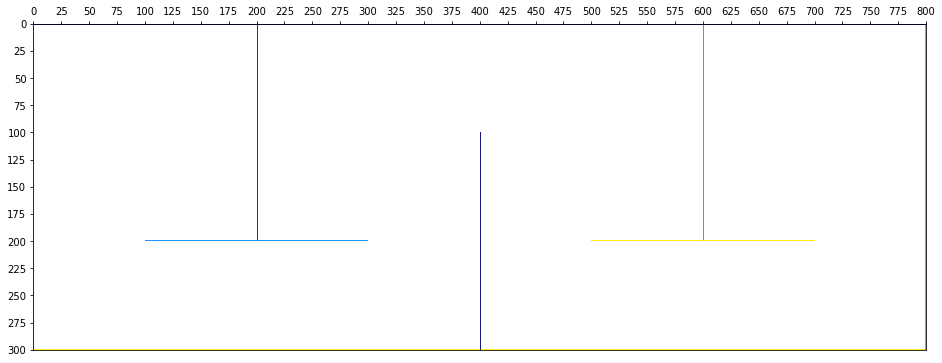

In [6]:
plot_polygons(env)

## Problem 1: Constructing Configuration Space

My C-space has grid size 1x1 with $5^\circ$ angular resolution.

### C-space by "adding" the robot polygon to all others
This "addition" is done as follows.
1. The reference frame of the robot is placed on the origin of the world reference.
2. For each polygon in the environment, a new polygon is computed as the convex hull of the Minkowski sum of the car (rotated by 180 degrees) and that polygon. (see `Polygon` class in `cspace.py` module for more details)

In [7]:
robot = cs.ReferenceRectangle([25, 25], 50, 50, 0)
augmented_env = cs.Environment(mapl(lambda poly: robot + poly, env))

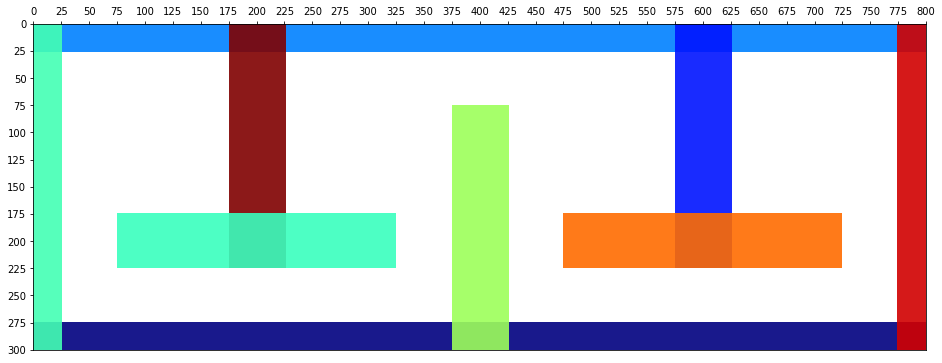

In [8]:
plot_polygons(augmented_env)

Above is what the C-space looks (for translation only) like when the car is 0 degrees with respect to the x-axis. Run the next cell a few times (with Ctrl+Enter) to see the C-space with different orientations.

Angle = 67 degrees.


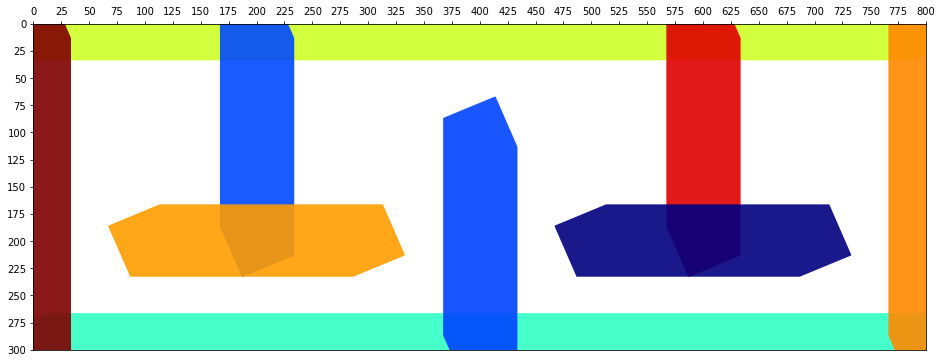

In [9]:
angle = np.random.randint(0, 90)
print(f'Angle = {angle} degrees.')
robot = cs.ReferenceRectangle([25, 25], 50, 50, angle)
random_aug_env = cs.Environment(mapl(lambda poly: robot + poly, env))
plot_polygons(random_aug_env)

The C-space for robot orientation of $0^\circ$ is:

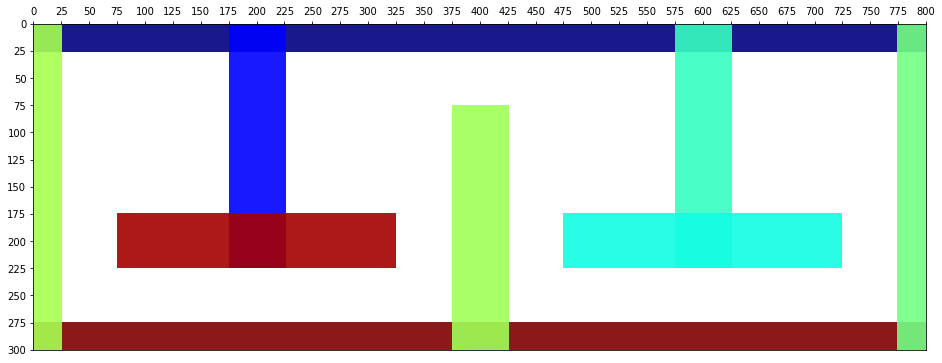

In [10]:
robot = cs.ReferenceRectangle([25, 25], 50, 50, 0)
augmented_env = cs.Environment(mapl(lambda poly: robot + poly, env))
plot_polygons(augmented_env)

The C-space for robot orientation of $45^\circ$ is:

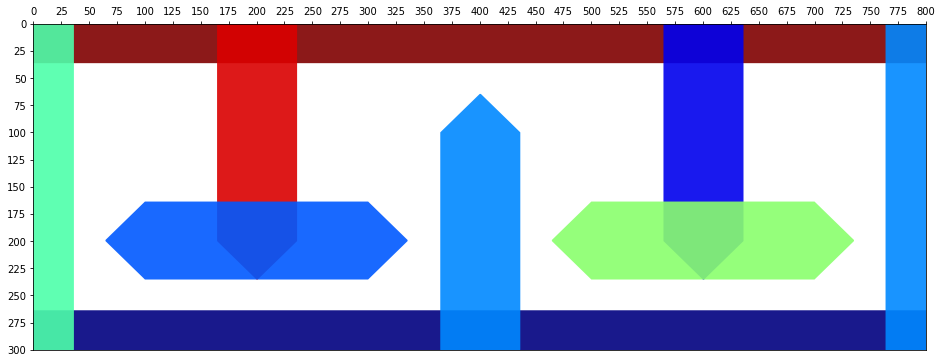

In [11]:
robot = cs.ReferenceRectangle([25, 25], 50, 50, 45)
augmented_env = cs.Environment(mapl(lambda poly: robot + poly, env))
plot_polygons(augmented_env)

The C-space for robot orientation of $90^\circ$ is: (identical to the the one for $0^\circ$)

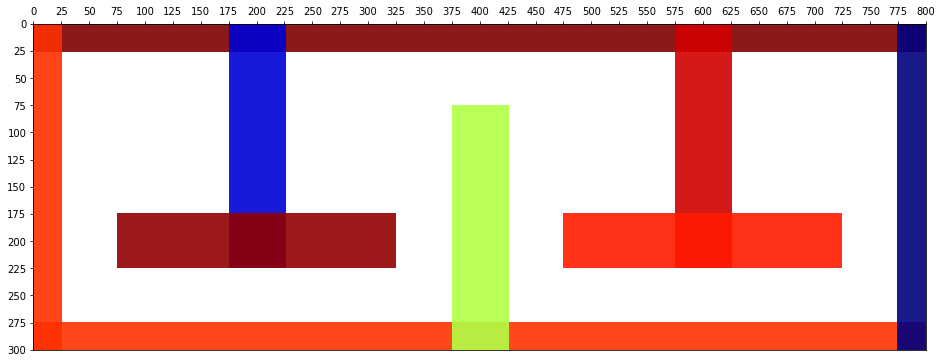

In [12]:
robot = cs.ReferenceRectangle([25, 25], 50, 50, 90)
augmented_env = cs.Environment(mapl(lambda poly: robot + poly, env))
plot_polygons(augmented_env)

Finally, let's construct the C-space and store it in a dict.

In [13]:
INTV = 5
cspace = {}
for theta in range(0, 91, 5):
    robot = cs.ReferenceRectangle([25, 25], 50, 50, theta)
    aug_env = cs.Environment(mapl(lambda poly: robot + poly, env))
    cspace[theta] = aug_env

## Problem 2: Exhaustive Search

First, let's construct the fully-connected graph. Constructing this graph takes a while so I recommend that you extract the attached zip file to get the pickle file.

In [14]:
try:
    with open('full_graph.pkl', 'rb') as gfile:
        full_graph = pickle.load(gfile)
except FileNotFoundError:
    full_graph = cs.make_graph(cspace)
    with open('full_graph.pkl', 'wb') as gfile:
        pickle.dump(full_graph, gfile)

In [15]:
print(f'The fully-connected graph has {full_graph.number_of_nodes()} nodes and {full_graph.number_of_edges()} edges.')

The fully-connected graph has 2137547 nodes and 3988985 edges.


Now we find the shortest path in our graph. I have ensured that the edges are connected appropriately across different orientations to give the optimal shortest path. Each of the graph vertices has three coordinates: $(x, y, \theta)$. However, there is one thing that makes this implementation a bit worse than truly optimal: the grid/angle resolution. For example, to move in the $5^\circ$ orientation, the robot has to move 11 units across and one unit up. This leads to a relatively big jump and sub-optimal graph-edge connections.

In [16]:
start = (50, 50, 90)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(full_graph, start, target)
shortest_path = np.array(shortest_path)

In [17]:
print(f'Length of shortest path is {length}.')

Length of shortest path is 1261.393283728201.


As we'll see later, this path is shorter than the paths obtained by all other methods and is the lower bound on them.

The path in 3D C-space looks as follows.

In [14]:
matplotlib.rcParams['figure.figsize'] = (16, 6)

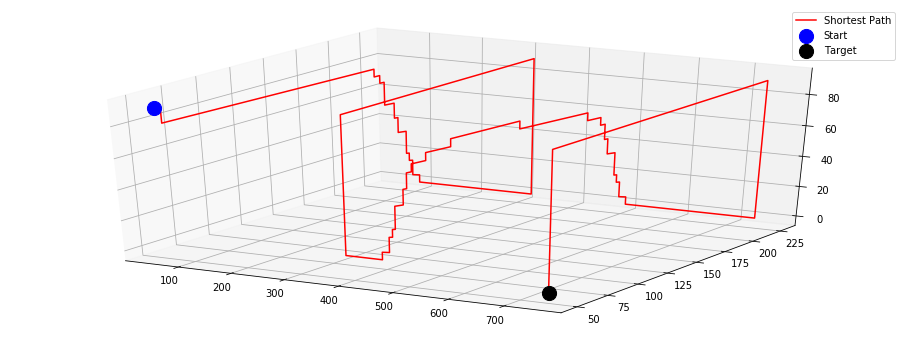

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')

ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

## Problem 3: Safest Path

We find the safest or 'Medial Axis Path', i.e., that path which is furthest away from obstacles. Using a robot of side length $50\sqrt{2}$ for a conservative safe estimate.

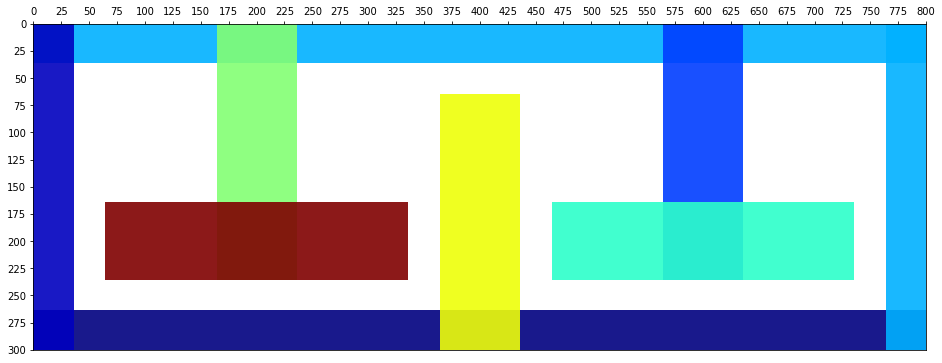

In [18]:
side = 50 * np.sqrt(2)
center = side / 2
robot = cs.ReferenceRectangle([center, center], side, side, 0)
voronoi_aug_env = cs.Environment(mapl(lambda poly: robot + poly, env))
plot_polygons(voronoi_aug_env)

In [19]:
from scipy.spatial import Voronoi
points = []
for polygon in voronoi_aug_env:
    points.extend(polygon.get_dense_edges(200))

vor = Voronoi(points)

In [20]:
# Vertices that are not in the interior of any obstacle and are not too far away
outer_vertices = []
for v in vor.vertices:
    x, y = v
    if (0 <= x < 801) and (0 <= y < 301):
        x, y = x, y
        if not voronoi_aug_env.in_obstacle((x, y)):
            outer_vertices.append((x, y))

In [21]:
outer_vertices = np.array(outer_vertices)

This is what our Voronoi vertices (labelled as "Nodes") look like:

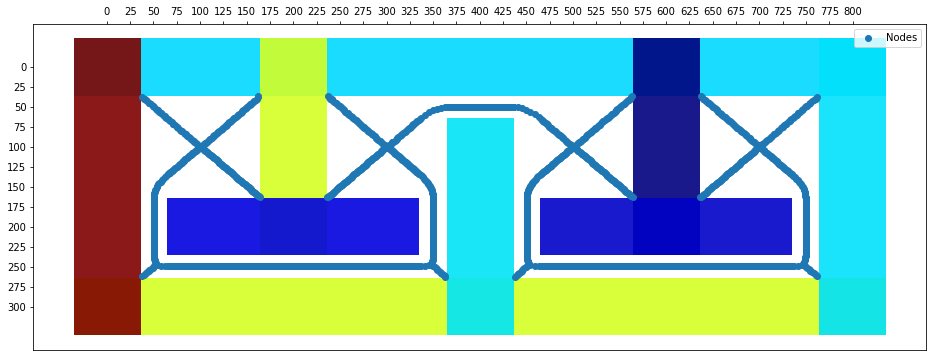

In [22]:
plot_polygons(voronoi_aug_env, None, outer_vertices)

Making a graph from the Voronoi vertices. To do this, I connect every valid (not inside an object) Voronoi vertex to its nearest 4-6 points. These nearest points are found using a bisection on the ball size with a KD-Tree.

In [31]:
def get_voronoi_neighbors(v, kdt, min_n=4, max_n=6):
    u = 0.5
    l = 0
    while True:
        ball_size = (u + l) / 2
        n_idxs = kdt.query_ball_point(v, ball_size)
        if len(n_idxs) < min_n:
            l = ball_size
            u *= 2
        elif len(n_idxs) > max_n:
            u = ball_size
            l /= 2
        else:
            break
    return n_idxs

def make_vorgraph(start, goal, verts):
    g = nx.Graph()
    kdt = cKDTree(verts)
    
    d, i = kdt.query(start)
    p = kdt.data[i]
    g.add_edge(tuple(start), tuple(p), weight=d)
    
    d, i = kdt.query(goal)
    p = kdt.data[i]
    g.add_edge(tuple(goal), tuple(p), weight=d)
    
    for v in kdt.data:
        n_idxs = get_voronoi_neighbors(v, kdt)
        for i in n_idxs:
            v_ = kdt.data[i]
            w = LA.norm(v - v_)
            g.add_edge(tuple(v), tuple(v_), weight=w)
    return g

In [32]:
start = (50, 50)
target = (750, 50)
vorgraph = make_vorgraph(start, target, outer_vertices)

In [33]:
vorgraph.number_of_edges()

9763

In [34]:
start = (50, 50)
target = (750, 50)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(vorgraph, start, target)
# length, shortest_path = nx.algorithms.single_source_dijkstra(graph, start, target)
shortest_path = np.array(shortest_path)

In [35]:
print(f'Length of safest path is {length}.')

Length of safest path is 1634.1360823318118.


The safest path looks as follows:

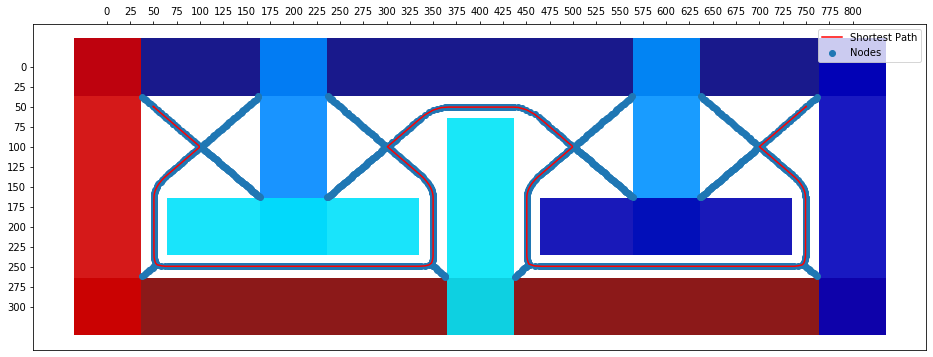

In [36]:
plot_polygons(voronoi_aug_env, shortest_path, outer_vertices)

# Problem 4: Probabilistic Roadmaps (PRMs)

Based on the explanation on Probabilistic Roadmaps in Planning Algorithms by Steven LaValle.

In [37]:
def build_roadmap(start, goal, cspace, NUM_SAMPLES=50):
    graph = nx.Graph()
    graph.add_node(start)
    graph.add_node(goal)
    samples_added = 0
    while samples_added < NUM_SAMPLES:
        graph_array = np.array(graph.nodes)
        point = random_point()
        kdt = cKDTree(graph_array[:, :2])
        d, i = kdt.query([point[0], point[1]], k=min(15, graph_array.shape[0]))
        neighbors = graph_array[i]
        connected = False
        for n in neighbors:
            if cs.check_edge_intersect([n[0], n[1]], [point[0], point[1]], cspace[n[2]]):
                if n[2] != point[2]:
                    connection = cs.check_add_edge(graph, point, (point[0], point[1], n[2]), cspace)
                    if not connection:
                        continue
                    added = cs.check_add_edge(graph, (point[0], point[1], n[2]), tuple(n), cspace)
                    connected |= added
        if connected:
            samples_added += 1
        connected = False
    return graph                       

### With 50 sample points

In [39]:
start = (50, 50, 90)
target = (750, 50, 0)
begin = time.time()
prm_graph_50 = build_roadmap(start, target, cspace, 50)
end = time.time()
print(f'Building this PRM took {end - begin:.4} seconds.')

Building this PRM took 12.18 seconds.


In [40]:
num_components = nx.components.number_connected_components(prm_graph_50)
print(f'The resulting graph has {num_components} connected components.')

The resulting graph has 2 connected components.


In [96]:
prm_nodes_50 = np.array(prm_graph_50.nodes)

With 50 samples, a path is usually not found. But I have plotted a graph for a lucky run a few cells below.

In [41]:
start = (50, 50, 90)
target = (750, 50, 0)
if num_components == 1:
    length, shortest_path = nx.algorithms.bidirectional_dijkstra(prm_graph_50, start, target)
    shortest_path = np.array(shortest_path)
else:
    print('Path cannot be found because there\'s more than one connected component.')


Path cannot be found because there's more than one connected component.


In [72]:
print(f'Length of shortest path is {length}.') # Lucky run

Length of shortest path is 1467.0666753894805.


The path in 3D C-space looks as follows.

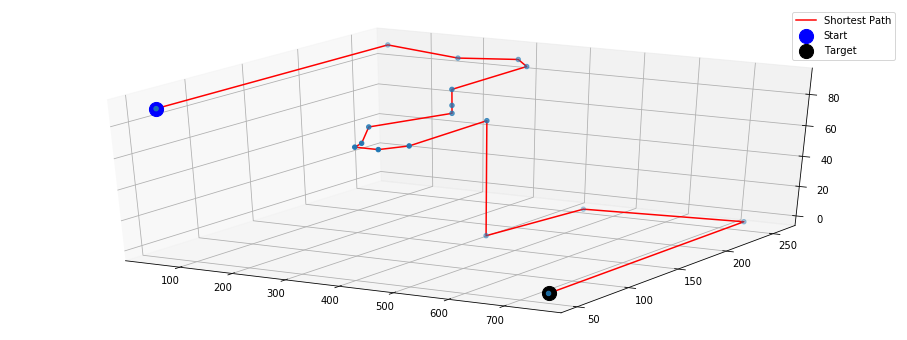

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')
# ax.scatter(prm_nodes_50[:, 0], prm_nodes_50[:, 1], prm_nodes_50[:, 2], label='PRM Nodes', c='green')

ax.scatter(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2])
ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

The path in 2D looks as follows. The blue points are all the points sampled by the PRM.

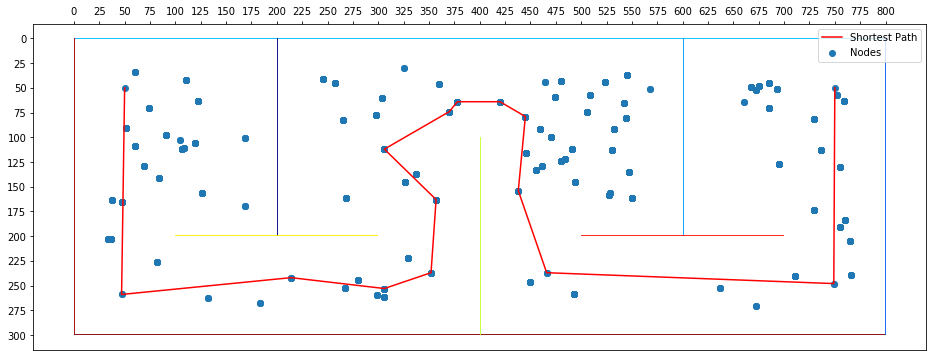

In [74]:
plot_polygons(env, shortest_path, prm_nodes_50)

Projecting the same graph on the C-space of $0^\circ$ orientation. (There may be some points inside the augmented obstacles, but in the appropriate orientation, they are not)

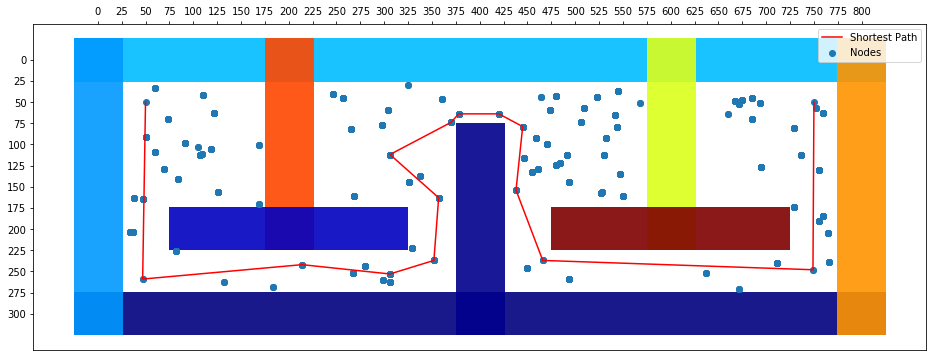

In [75]:
plot_polygons(cspace[0], shortest_path, prm_nodes_50)

Note that the above plot is just a lucky run using 50 samples. More often than not, a path from the source to the goal is not found for just 50 samples.

### With 100 sample points

In [89]:
start = (50, 50, 90)
target = (750, 50, 0)
begin = time.time()
prm_graph_100 = build_roadmap(start, target, cspace, 100)
end = time.time()
print(f'Building this PRM took {end - begin:.4} seconds.')

Building this PRM took 23.72 seconds.


In [114]:
num_components = nx.components.number_connected_components(prm_graph_100)
print(f'The resulting graph has {num_components} connected components.')

The resulting graph has 1 connected components.


In [115]:
prm_nodes_100 = np.array(prm_graph_100.nodes)

In [116]:
start = (50, 50, 90)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(prm_graph_100, start, target)
# length, shortest_path = nx.algorithms.single_source_dijkstra(graph, start, target)
shortest_path = np.array(shortest_path)

In [117]:
print(f'Length of shortest path is {length}.')

Length of shortest path is 1453.5450442696692.


The path in 3D C-space looks as follows.

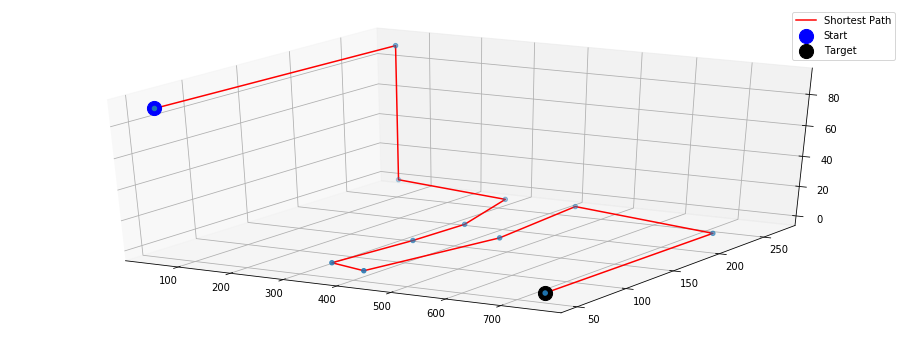

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')

ax.scatter(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2])
ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

The path in 2D looks as follows.

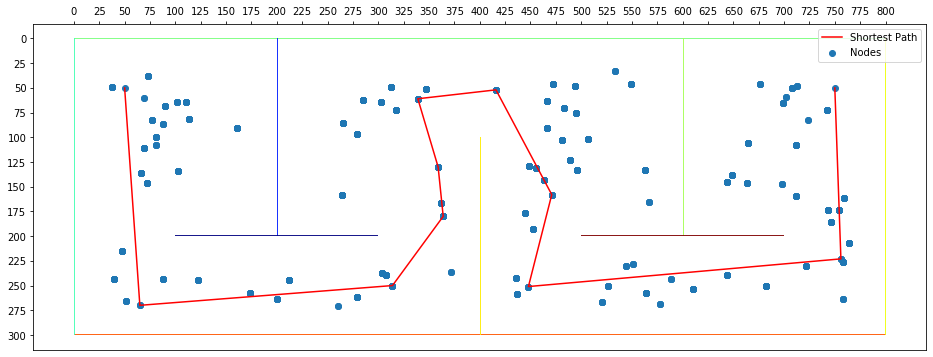

In [121]:
plot_polygons(env, shortest_path, prm_nodes_100)

Projecting the same graph on the C-space of $0^\circ$ orientation. (There may be some points inside the augmented obstacles, but in the appropriate orientation, they are not)

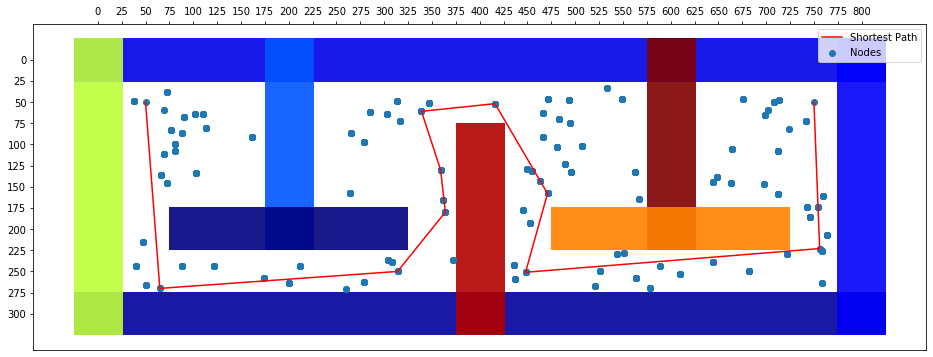

In [122]:
plot_polygons(cspace[0], shortest_path, prm_nodes_100)

### With 500 sample points

In [62]:
start = (50, 50, 90)
target = (750, 50, 0)
begin = time.time()
prm_graph_500 = build_roadmap(start, target, cspace, 500)
end = time.time()
print(f'Building this PRM took {end - begin:.4} seconds.')

Building this PRM took 39.57 seconds.


In [63]:
num_components = nx.components.number_connected_components(prm_graph_500)
print(f'The resulting graph has {num_components} connected components.')

The resulting graph has 1 connected components.


In [64]:
prm_nodes_500 = np.array(prm_graph_500.nodes)

In [65]:
start = (50, 50, 90)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(prm_graph_500, start, target)
# length, shortest_path = nx.algorithms.single_source_dijkstra(graph, start, target)
shortest_path = np.array(shortest_path)

In [66]:
print(f'Length of shortest path is {length}.')

Length of shortest path is 1356.7538347385644.


The path in 3D C-space looks as follows.

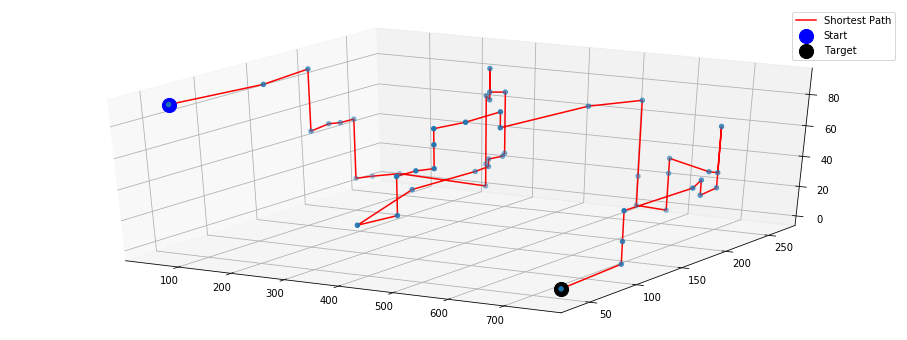

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')

ax.scatter(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2])
ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

The path in 2D looks as follows.

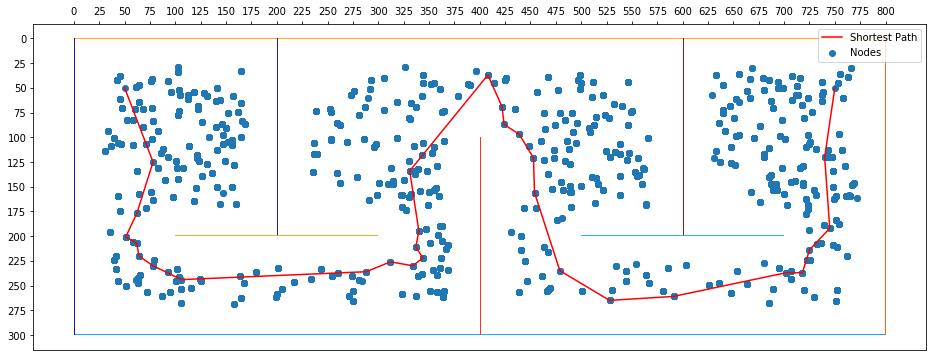

In [68]:
plot_polygons(env, shortest_path, prm_nodes_500)

Projecting the same graph on the C-space of $0^\circ$ orientation. (There may be some points inside the augmented obstacles, but in the appropriate orientation, they are not)

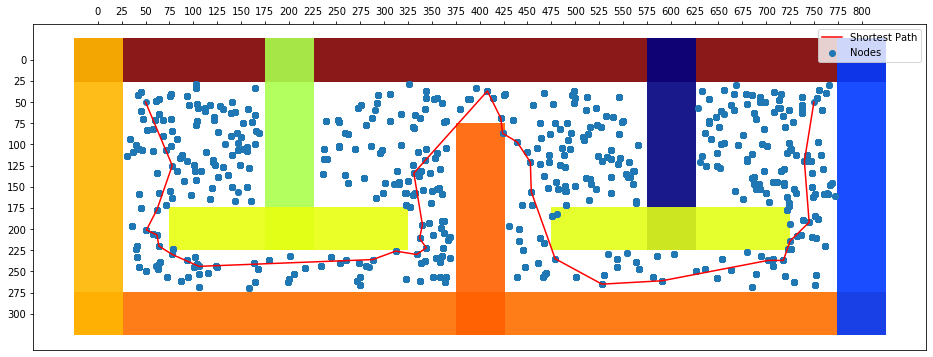

In [69]:
plot_polygons(cspace[0], shortest_path, prm_nodes_500)

### Performance for different sample sizes

With this implementation of probabilistic roadmaps (PRMs) for different sample sizes, we can make the following observations.

1. With 50 samples, more of than not, a path between the source and the goal cannot be found. There is more than one (usually 2) connected components.
2. With 100 samples, only sometimes a path is not found.
3. With 500 samples, a path is always (in the times I've run it) found.
4. When a path is found, the one with 500 samples (most likely) is the shortest, followed by the one with 100 samples, and the one with 50 samples is the longest.

# Problem 5: Rapidly-exploring Random Rree (RRT)

In [23]:
MAX_ITERS = int(1e4)
# Probability of selecting the goal node as the new random node
EPS = 0.01

RRT Helper functions:

In [43]:
def find_nearest(qnew, graph):
    x, y, _ = qnew
    nearest = min(graph.nodes,
                  key=lambda p: LA.norm((x - p[0], y - p[1])))
    return nearest

def cart_vec(q):
    return np.array([q[0], q[1], 0])

def chain(qnear, qnew, graph, cspace, link_length=5):
    end_reached = False
    
    while not end_reached:
        vnear, vnew = cart_vec(qnear), cart_vec(qnew)
        if LA.norm(vnew - vnear) <= link_length:
            qnext = qnew
            end_reached = True
        else:
            unitv = (vnew - vnear) / LA.norm(vnew - vnear)
            qnext = vnear + (link_length * unitv)
            qnext[2] = qnear[2]
            qnext = qnext.astype(int)
        if cs.check_edge_intersect(qnear, qnext, cspace[qnear[2]]):
            added = cs.check_add_edge(graph, tuple(qnear),
                                      tuple(qnext), cspace)
            if not added:
                break
        else:
            break
        qnear = qnext

RRT algorithm. Based on Planning Algorithms by Steven LaValle.

In [44]:
def make_rrt(qstart, qgoal, cspace, link_length):
    graph = nx.Graph()
    graph.add_node(qstart)
    for _ in range(MAX_ITERS):
        if np.random.random() < EPS:
            qnew = qgoal
        else:
            qnew = random_point()
            if cspace[qnew[2]].in_obstacle((qnew[0], qnew[1])):
                continue
        qnear = find_nearest(qnew, graph)
        chain(qnear, qnew, graph, cspace, link_length)
        if qgoal in graph:
            break
    return graph

### With link length = 5

In [72]:
start = (50, 50, 90)
target = (750, 50, 0)
begin = time.time()
rrt_graph = make_rrt(start, target, cspace, 5)
end = time.time()
print(f'Computing RRT took {end - begin:.4} seconds.')

Computing RRT took 3.114 seconds.


In [73]:
rrt_nodes = np.array(rrt_graph.nodes)

In [74]:
print(f'The RRT graph has {rrt_graph.number_of_nodes()} nodes and {rrt_graph.number_of_edges()} edges.')

The RRT graph has 1154 nodes and 1154 edges.


This graph (tree) has **far** fewer nodes than the exhaustive fully-connected graph.

In [75]:
start = (50, 50, 90)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(rrt_graph, start, target)
# length, shortest_path = nx.algorithms.single_source_dijkstra(graph, start, target)
shortest_path = np.array(shortest_path)

In [76]:
print(f'Length of shortest path is {length}.')

Length of shortest path is 1674.3394416510585.


The path in 3D C-space looks as follows.

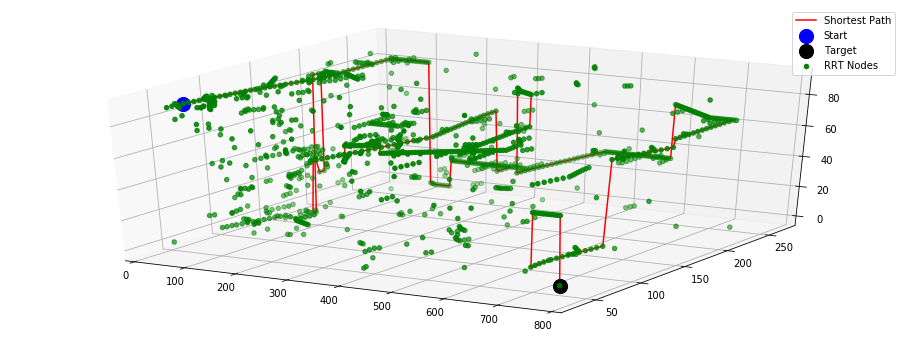

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')
ax.scatter(rrt_nodes[:, 0], rrt_nodes[:, 1], rrt_nodes[:, 2], label='RRT Nodes', c='green')

# ax.scatter(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2])
ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

The path in 2D looks as follows. The blue points are all the places that the RRT explored.

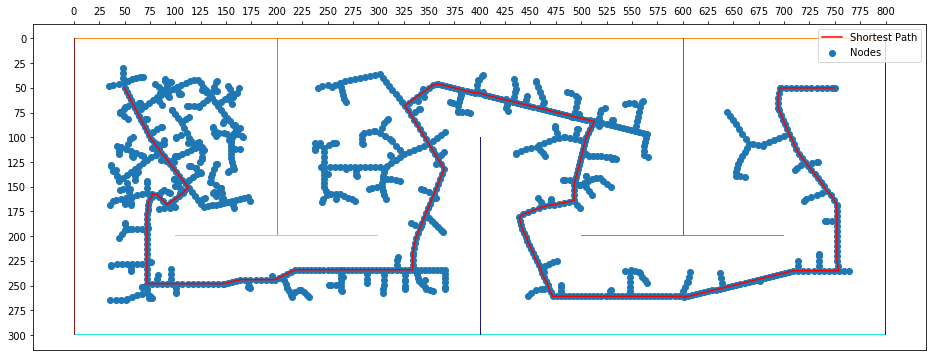

In [78]:
plot_polygons(env, shortest_path, rrt_nodes)

Projecting the same graph on the C-space of $0^\circ$ orientation. (There may be some points inside the augmented obstacles, but in the appropriate orientation, they are not)

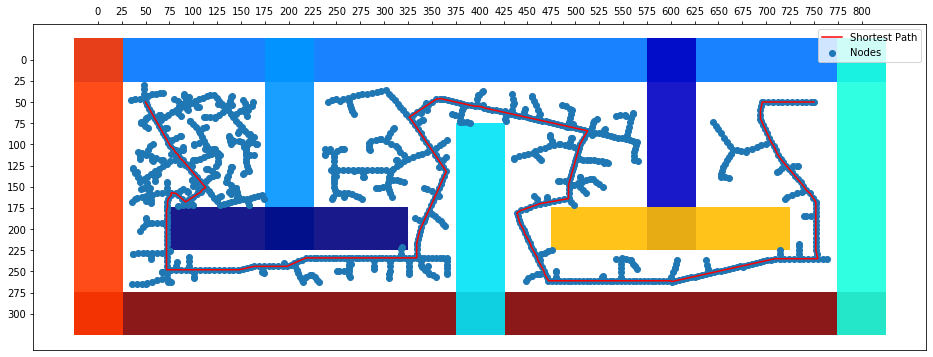

In [79]:
plot_polygons(cspace[0], shortest_path, rrt_nodes)

### With link length = 10

In [80]:
start = (50, 50, 90)
target = (750, 50, 0)
begin = time.time()
rrt_graph = make_rrt(start, target, cspace, 10)
end = time.time()
print(f'Computing RRT took {end - begin:.4} seconds.')

Computing RRT took 2.628 seconds.


In [81]:
rrt_nodes = np.array(rrt_graph.nodes)

In [82]:
print(f'The RRT graph has {rrt_graph.number_of_nodes()} nodes and {rrt_graph.number_of_edges()} edges.')

The RRT graph has 739 nodes and 739 edges.


This graph (tree) has **far** fewer nodes than the exhaustive fully-connected graph.

In [83]:
start = (50, 50, 90)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(rrt_graph, start, target)
# length, shortest_path = nx.algorithms.single_source_dijkstra(graph, start, target)
shortest_path = np.array(shortest_path)

In [84]:
print(f'Length of shortest path is {length}.')

Length of shortest path is 1520.1962804947118.


The path in 3D C-space looks as follows.

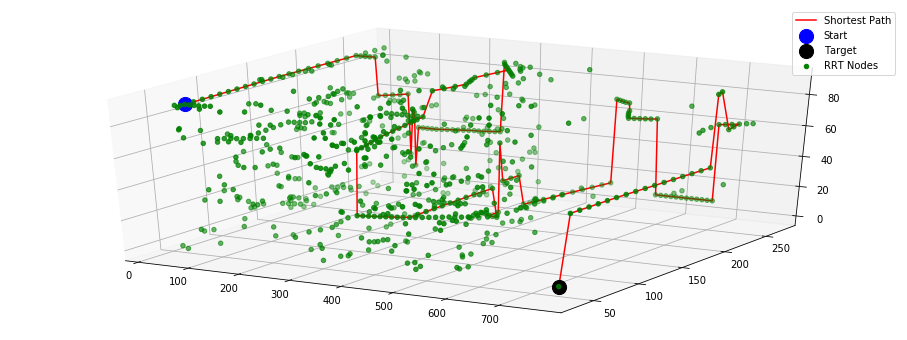

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')
ax.scatter(rrt_nodes[:, 0], rrt_nodes[:, 1], rrt_nodes[:, 2], label='RRT Nodes', c='green')

# ax.scatter(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2])
ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

The path in 2D looks as follows. The blue points are all the places that the RRT explored.

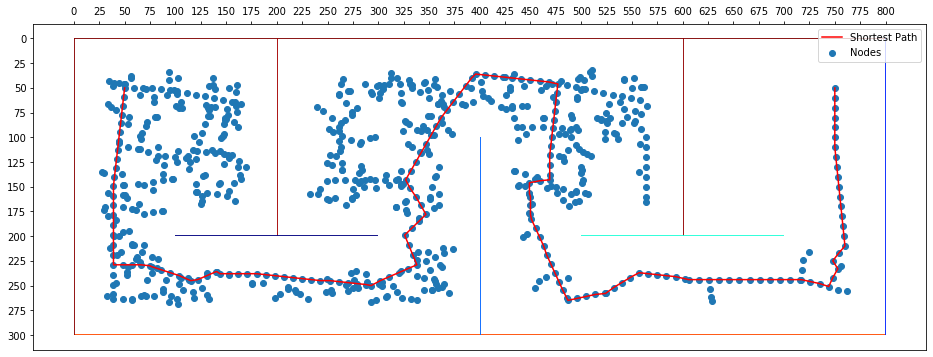

In [86]:
plot_polygons(env, shortest_path, rrt_nodes)

Projecting the same graph on the C-space of $0^\circ$ orientation. (There may be some points inside the augmented obstacles, but in the appropriate orientation, they are not)

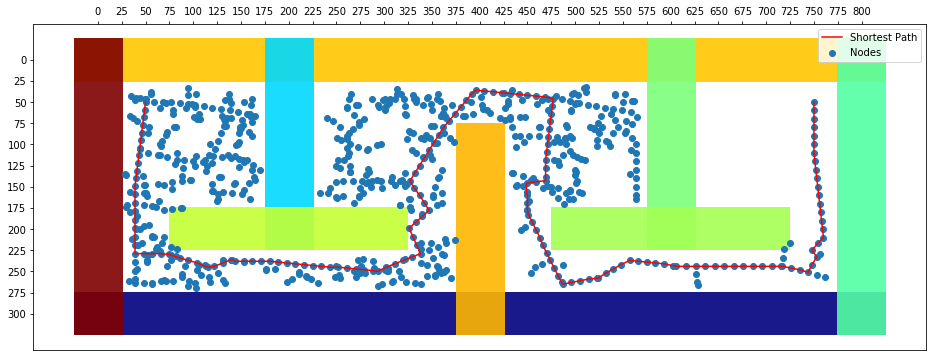

In [87]:
plot_polygons(cspace[0], shortest_path, rrt_nodes)

### With link length = 50

In [88]:
start = (50, 50, 90)
target = (750, 50, 0)
begin = time.time()
rrt_graph = make_rrt(start, target, cspace, 50)
end = time.time()
print(f'Computing RRT took {end - begin:.4} seconds.')

Computing RRT took 1.826 seconds.


In [89]:
rrt_nodes = np.array(rrt_graph.nodes)

In [90]:
print(f'The RRT graph has {rrt_graph.number_of_nodes()} nodes and {rrt_graph.number_of_edges()} edges.')

The RRT graph has 381 nodes and 380 edges.


This graph (tree) has **far** fewer nodes than the exhaustive fully-connected graph.

In [91]:
start = (50, 50, 90)
target = (750, 50, 0)
length, shortest_path = nx.algorithms.bidirectional_dijkstra(rrt_graph, start, target)
# length, shortest_path = nx.algorithms.single_source_dijkstra(graph, start, target)
shortest_path = np.array(shortest_path)

In [92]:
print(f'Length of shortest path is {length}.')

Length of shortest path is 1611.924198330343.


The path in 3D C-space looks as follows.

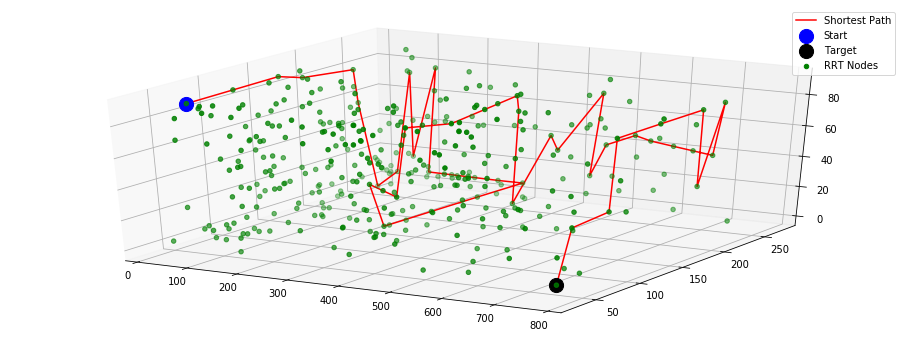

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(start[0], start[1], start[2], label='Start', s=200, c='blue')
ax.scatter(target[0], target[1], target[2], label='Target', s=200, c='black')
ax.scatter(rrt_nodes[:, 0], rrt_nodes[:, 1], rrt_nodes[:, 2], label='RRT Nodes', c='green')

# ax.scatter(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2])
ax.plot(shortest_path[:, 0], shortest_path[:, 1], shortest_path[:, 2], c='red', label='Shortest Path')
plt.legend()
plt.show()

The path in 2D looks as follows. The blue points are all the places that the RRT explored.

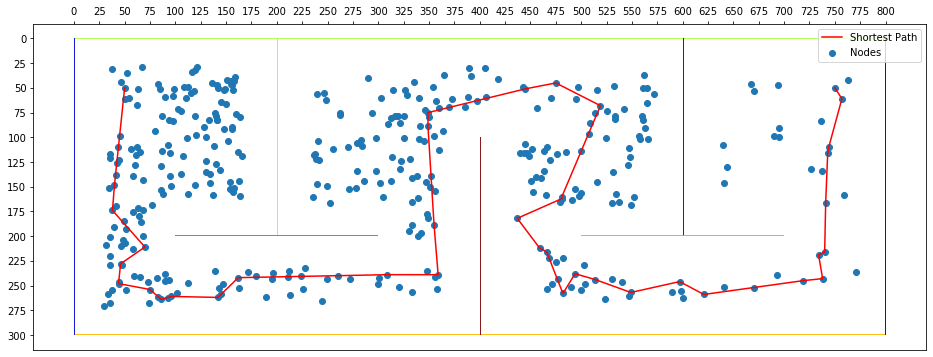

In [94]:
plot_polygons(env, shortest_path, rrt_nodes)

Projecting the same graph on the C-space of $0^\circ$ orientation. (There may be some points inside the augmented obstacles, but in the appropriate orientation, they are not)

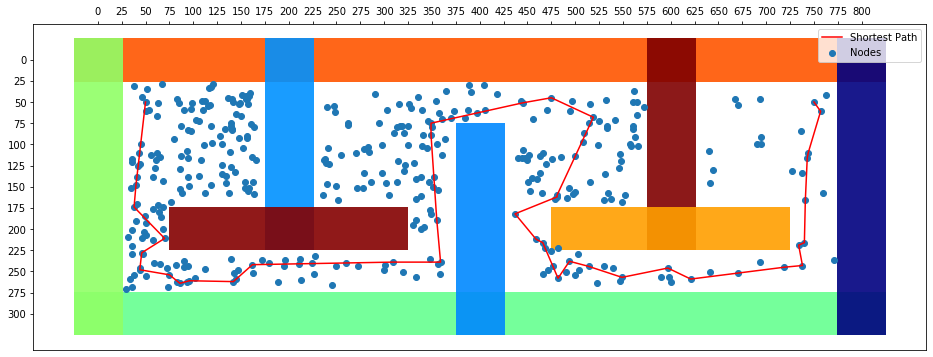

In [95]:
plot_polygons(cspace[0], shortest_path, rrt_nodes)

### Main (performance) differences between PRM and RRT

1. In these experiments, a single run for an RRT is much faster than that for a PRM. The RRT run takes ~1-3s while the PRM takes 10's of seconds.
2. The path found by the PRM (especially the one with 500 samples) is usually significantly shorter than the one found by the RRT. The 500-sample PRM is closest to the exhaustive shortest path (though still about 100 units greater).
3. After the initial build time, running PRMs (with sufficient number of samples) for multiple queries would be very efficient.
4. For single-query problems, RRTs are quite fast and useful.

# References

1. [Planning Algorithms by Steven M. LaValle (sections 5.1-5.6)](http://planning.cs.uiuc.edu/)
2. [Robot Motion Planning lecture by Howie Choset](https://www.cs.cmu.edu/~motionplanning/lecture/lec20.pdf)